In [5]:
import numpy as np
import math
from scipy.optimize import linprog
from abc import ABC
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

In [6]:
def generate_bit_data(n = 1000): 
    """
    Generate an array of n random bits.
    """
    return np.random.randint(0,2,n)

class Mechanism(ABC): 
    pass

class NoiseMechanism(Mechanism):
    """
    A mechanism whose queries return the true result plus noise generated by noise_generator. 
    noise_generator takes 0 arguments and returns a value of the same type as query
    """

    def __init__(self, dataset, noise_generator):
        self.dataset = dataset
        self.length = len(dataset)   
        self.noise_generator = noise_generator
        
    def get_len(self):
        return self.length
    
    def get_raw_data(self):
        return self.dataset

    def query(self, indices): 
        result = np.sum(self.dataset[indices])
        noise = self.noise_generator()
        return result + noise
    
class LaplaceMechanism(NoiseMechanism):
    """
    A noise mechanism that draws its noise from the Laplace(sensitivity/epsilon) distribution
    """
    def __init__(self, dataset, epsilon, sensitivity=1):
        self.scale = (sensitivity/epsilon)
        noise = lambda : np.random.laplace(loc=0,scale = self.scale, size=None)
        super().__init__(dataset, noise)
    
class GaussianMechanism(NoiseMechanism):
    """
    A noise mechanism that draws its noise from the Normal(2*(sensitivity^2)log(1/25/delta)/(epsilon^2))distribution
    """
    
    def __init__(self, dataset, epsilon, delta, sensitivity = 1):
        self.scale = (2 * (sensitivity ** 2) * math.log(1.25/delta)) / (epsilon ** 2)
        noise_generator = np.random.normal(loc=0, scale=self.scale, size=None)
        super().__init__(dataset, noise_generator)
    
    
def dinur_nissim(mech, epsilon = 0.5, gen_t = lambda n : n * (math.log2(n) ** 2), should_log = False):
    """
    Perform a dinur_nissim attack on the dataset, mediated by mech, a Mechanism object. 
    
    epsilon and t are the two hyperparameters of the attack. gen_t generates int-valued t as a function of n, the size of the dataset.
    
    Wrap all logging behond `should_log`
    """
    
    n = mech.get_len()
    t = int(gen_t(n))

    def generate_query():
        # Generate a random subset of [n] by generating a list of bits and convert to indices
        q_j = np.random.randint(0,2,n)
        indices2 = q_j.nonzero()
        return (q_j, indices2) 
    
    # Make t queries to the mechanism. A_ub and b_ub are respectively the coefficient matrix 
    #   and upper bound for the linear program 
    A_ub = []
    b_ub = []
    for _ in range(int(t)):
        q, indices = generate_query()
        answer = mech.query(indices)
        A_ub.append(q)
        b_ub.append(answer + epsilon)
        A_ub.append(-1 * q)
        b_ub.append(epsilon - answer)
    A_ub = np.vstack(A_ub)
    b_ub = np.array(b_ub)
    # Rounding Phase: round the results of the LP into integers
    
    if(should_log):
        print(f"Solving LP with {len(b_ub)} constraints")
    program_result = linprog(np.zeros(n), np.vstack(A_ub), b_ub, bounds=(0,1))

    if(should_log):    
        print(f"Done w/ LP")
    round_vector = np.vectorize(round, otypes=[int])
    return round_vector(program_result["x"])


def percent_reconstructed(data, results): 
    """
    What percentage of entries in data match those in results.
    """
    n = len(data)
    return 1 - ((np.count_nonzero(data!=results))/n)

In [7]:

# Very simple example
# data = generate_bit_data(n=500)
# mech = LaplaceMechanism(data, epsilon=100)
# dinur_nissim(mech, gen_t=lambda n : n)

In [28]:
def run_experiment(ns, mechanism_class, mech_args, dn_epsilons, t_generators, should_log=True, output_filename = None): 
    
    results_df =  pd.DataFrame(columns=["n", 
                              *list(mech_args[0].keys()), 
                              "dn_espsilon", 
                              "num_queries", 
                              "percent_reconstructed"]) 
    
    def make_entry(mech_arg, n, dn_epsilon, t, pc_reconstructed): 
        res = {x : [mech_arg[x]] for x in mech_arg.keys()}
        res.update (
            {
                "n" : [n],
                "dn_espsilon" : [dn_epsilon],
                "num_queries" : [t],
                "percent_reconstructed" : pc_reconstructed
            }
        )
        return pd.DataFrame.from_dict(res)
 
    total = len(ns)*len(mech_args)*len(dn_epsilons)*len(t_generators)
    if(should_log):
        print(f"Running {total} experiments")
        
    so_far = 0
    for n in ns:
        for mech_arg in mech_args:
            # New dataset and mech for each size/mechanism params pair
            data = generate_bit_data(n=n)
            mech = mechanism_class(data, **mech_arg)
            for dn_epsilon in dn_epsilons: 
                for t_generator in t_generators:
                    result = dinur_nissim(mech, dn_epsilon,t_generator)
                    # Lambdas are hard to log so we log its application. We can probably abstract this better.
                    t = int(t_generator(n))
                    
                    # Append new results 
                    entry = make_entry(mech_arg, n, dn_epsilon, t, percent_reconstructed(data, result))
                    results_df = pd.concat([results_df, entry], ignore_index=True)     
                    so_far += 1
                    if should_log:
                        print(f"Finished {so_far}/{total}")
                        
    if output_filename:
        if should_log:
            printf(f"Writing results to {output_filename}")
        df.to_csv(output_filename, encoding='utf-8', header='true')
    return results_df

In [26]:
class Ascending:
    def __init__(self, start):
        self.current = start
    
    def __call__(self, x):
        return self.current
    
    
asc = Ascending(400)


# Example usage. Essentially runs over the cartesian product of the lists [ns, mech_args, dn_epsilons, t_generators]
r = run_experiment(
    ns = [1000], 
    mechanism_class = LaplaceMechanism, 
    mech_args = [{"epsilon": x} for x in [.1*y for y in range(3, 16)]], 
    dn_epsilons=[.5], 
    t_generators=([Ascending(n) for n in [50*y for y in range(8, 14)]]), output_filename="")


Running 78 experiments
Finished 1/78
Finished 2/78
Finished 3/78
Finished 4/78
Finished 5/78
Finished 6/78
Finished 7/78
Finished 8/78
Finished 9/78
Finished 10/78
Finished 11/78
Finished 12/78
Finished 13/78
Finished 14/78
Finished 15/78
Finished 16/78
Finished 17/78
Finished 18/78
Finished 19/78
Finished 20/78
Finished 21/78
Finished 22/78
Finished 23/78
Finished 24/78
Finished 25/78
Finished 26/78
Finished 27/78
Finished 28/78
Finished 29/78
Finished 30/78
Finished 31/78
Finished 32/78
Finished 33/78
Finished 34/78
Finished 35/78
Finished 36/78
Finished 37/78
Finished 38/78
Finished 39/78
Finished 40/78
Finished 41/78
Finished 42/78
Finished 43/78
Finished 44/78
Finished 45/78
Finished 46/78
Finished 47/78
Finished 48/78
Finished 49/78
Finished 50/78
Finished 51/78
Finished 52/78
Finished 53/78
Finished 54/78
Finished 55/78
Finished 56/78
Finished 57/78
Finished 58/78
Finished 59/78
Finished 60/78
Finished 61/78
Finished 62/78
Finished 63/78
Finished 64/78
Finished 65/78
Finished 66

In [29]:
r

,n,epsilon,dn_espsilon,num_queries,percent_reconstructed
0,1000,0.3,0.5,400,0.698
1,1000,0.3,0.5,450,0.720
2,1000,0.3,0.5,500,0.717
3,1000,0.3,0.5,550,0.730
4,1000,0.3,0.5,600,0.755
...,...,...,...,...,...
73,1000,1.5,0.5,450,0.825
74,1000,1.5,0.5,500,0.869
75,1000,1.5,0.5,550,0.952
76,1000,1.5,0.5,600,0.995


/var/folders/mk/ydf2207j325_0l9ph1swkbzc0000gq/T/ipykernel_52466/947076135.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


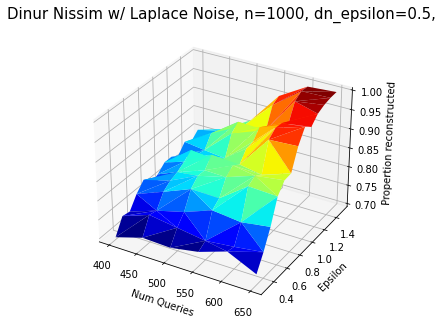

In [37]:
fig = plt.figure()

ax = Axes3D(fig)
ax.plot_trisurf(r.num_queries, r.epsilon, r.percent_reconstructed, cmap=cm.jet, linewidth=0.2)
ax.set_xlabel('Num Queries', fontsize=10)
ax.set_ylabel('Epsilon', fontsize=10)
ax.set_zlabel('Propertion reconstructed', fontsize=10)
ax.set_title('Dinur Nissim w/ Laplace Noise, n=1000, dn_epsilon=0.5,', fontsize=15)



plt.show()

In [23]:
at_600 = r[r.num_queries == 600]



<AxesSubplot:xlabel='epsilon'>

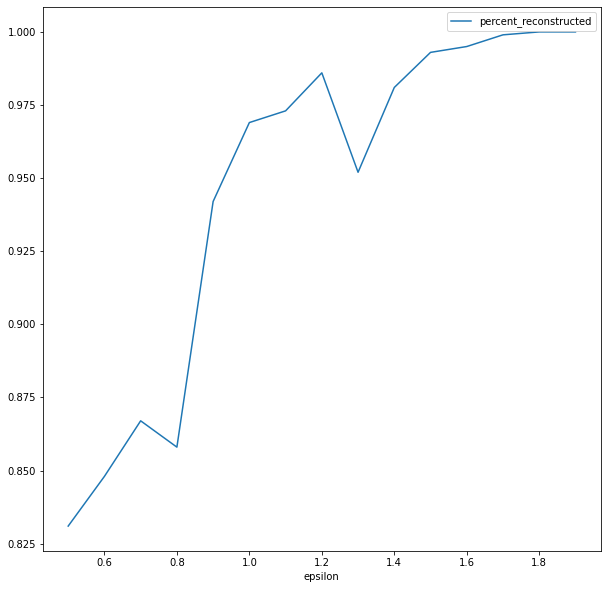

In [25]:
at_600.plot(x="epsilon", y=["percent_reconstructed"],
        kind="line", figsize=(10, 10))